In [1]:
# Load libraries  # I only remove duplcate imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.neighbors as nb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, fbeta_score, make_scorer
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as cv
import sklearn.neighbors as nb
from sklearn.metrics import recall_score, make_scorer
from imblearn.under_sampling import InstanceHardnessThreshold
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [2]:
def get_redundant_pairs(corr):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = corr.columns
    for i in range(0, corr.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(corr, n):
    au_corr = corr.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [4]:
# Load data
full_data = pd.read_csv("heart_attack_prediction_indonesia.csv", 
                        na_values=['NA', 'N/A'],
                        keep_default_na=False)

original_columns = full_data.drop(columns=['heart_attack']).columns.tolist()
categorical_columns = ['gender', 'region', 'income_level', 'smoking_status', 
            'alcohol_consumption', 'physical_activity', 'dietary_habits', 
            'air_pollution_exposure', 'stress_level', 'EKG_results']


full_data.head(n=10)

,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,...,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
0,60,Male,Rural,Middle,0,1,211,0,83,0,...,62,173,48,121,101,Normal,0,0,0,0
1,53,Female,Urban,Low,0,0,208,0,106,1,...,76,70,58,83,138,Normal,1,0,1,0
2,62,Female,Urban,Low,0,0,231,1,112,1,...,74,118,69,130,171,Abnormal,0,1,0,1
3,73,Male,Urban,Low,1,0,202,0,82,1,...,65,98,52,85,146,Normal,0,1,1,0
4,52,Male,Urban,Middle,1,0,232,0,89,0,...,75,104,59,127,139,Normal,1,0,1,1
5,52,Male,Urban,Middle,0,0,231,1,81,1,...,71,129,34,148,191,Normal,0,1,1,0
6,73,Female,Rural,Low,0,0,238,1,91,0,...,97,88,40,128,167,Normal,0,1,1,0
7,64,Female,Urban,Low,0,1,165,0,72,1,...,83,112,47,100,50,Normal,0,0,1,1
8,49,Female,Urban,Low,0,0,186,0,115,0,...,87,147,46,157,198,Abnormal,0,1,0,0
9,61,Male,Rural,Low,0,0,121,1,88,1,...,87,79,34,93,164,Normal,0,0,0,1


## Check correlations -> If two variables have a correlation > 0.5 between them, we could think to discard one of them or merging them, not to overweight some tendencies 

In [5]:
corr = full_data.drop(columns=categorical_columns)
corr.corr().T.style.background_gradient(cmap = "Oranges")

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,fasting_blood_sugar,cholesterol_hdl,cholesterol_ldl,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack
age,1.000000,-0.000512,0.003616,-0.003747,-0.001556,0.001601,0.001046,0.000996,-0.001945,0.001823,0.001721,0.002060,0.000313,0.001071,-0.000475,-0.003072,-0.000620,0.105756
hypertension,-0.000512,1.000000,-0.001329,-0.001085,-0.002454,0.000724,0.000391,0.001773,-0.002323,-0.000049,0.001431,-0.000334,-0.000579,0.000362,-0.004754,0.003349,-0.002905,0.269261
diabetes,0.003616,-0.001329,1.000000,-0.001019,0.001720,-0.001773,-0.001133,0.001436,-0.004286,-0.002648,0.002989,0.000479,0.003871,-0.002776,0.000584,0.002031,-0.002566,0.194512
cholesterol_level,-0.003747,-0.001085,-0.001019,1.000000,-0.000630,-0.000419,-0.002900,0.001566,-0.000771,0.001419,-0.001864,0.003067,0.000929,0.000118,-0.004461,0.003451,-0.000869,0.092611
obesity,-0.001556,-0.002454,0.001720,-0.000630,1.000000,0.395426,0.001415,0.003177,0.001068,-0.000498,0.002241,0.001893,-0.001063,-0.001200,-0.001761,-0.004153,-0.003739,0.171720
waist_circumference,0.001601,0.000724,-0.001773,-0.000419,0.395426,1.000000,0.000109,0.002004,0.000340,0.002217,0.003899,-0.002747,-0.000781,0.000694,0.000844,0.000056,-0.002741,0.067883
family_history,0.001046,0.000391,-0.001133,-0.002900,0.001415,0.000109,1.000000,0.001150,-0.000897,0.002180,0.004453,-0.004747,0.002161,-0.000026,0.001014,-0.000015,0.002573,0.001374
sleep_hours,0.000996,0.001773,0.001436,0.001566,0.003177,0.002004,0.001150,1.000000,-0.000589,0.003410,-0.001069,-0.002888,-0.001024,-0.002672,0.002168,0.003941,-0.002101,0.000673
blood_pressure_systolic,-0.001945,-0.002323,-0.004286,-0.000771,0.001068,0.000340,-0.000897,-0.000589,1.000000,-0.002384,-0.001058,-0.005929,0.001367,-0.003280,0.003781,0.000549,0.001929,-0.001644
blood_pressure_diastolic,0.001823,-0.000049,-0.002648,0.001419,-0.000498,0.002217,0.002180,0.003410,-0.002384,1.000000,-0.000854,0.001408,-0.002969,-0.000498,-0.004296,0.002096,0.000923,-0.000301


In [6]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(corr, 9))

Top Absolute Correlations
obesity                 waist_circumference    0.395426
previous_heart_disease  heart_attack           0.274775
hypertension            heart_attack           0.269261
diabetes                heart_attack           0.194512
obesity                 heart_attack           0.171720
age                     heart_attack           0.105756
cholesterol_level       heart_attack           0.092611
fasting_blood_sugar     heart_attack           0.069826
waist_circumference     heart_attack           0.067883
dtype: float64


In [7]:
full_data.describe(include=object)

,gender,region,income_level,smoking_status,alcohol_consumption,physical_activity,dietary_habits,air_pollution_exposure,stress_level,EKG_results
count,158355,158355,158355,158355,158355,158355,158355,158355,158355,158355
unique,2,2,3,3,3,3,2,3,3,2
top,Male,Urban,Middle,Never,None,Low,Unhealthy,Moderate,Moderate,Normal
freq,82243,103038,71230,79183,94848,63417,95030,79144,79366,126914


In [8]:
full_data.groupby('heart_attack').size()

heart_attack
0    94854
1    63501
dtype: int64

<Axes: xlabel='heart_attack'>

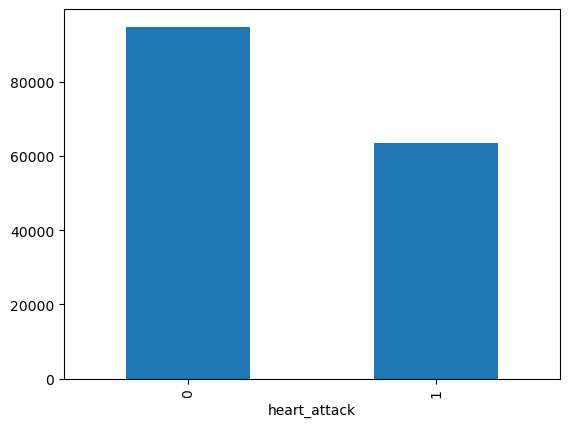

In [9]:
full_data.heart_attack.value_counts().plot(kind='bar')

In [10]:
y = full_data['heart_attack']
X = full_data.drop(columns=['heart_attack'])

## We apply check before taking dummies the number of different elements in each category to avoid increase a lot (potentially) the computational cost of the training.



In [12]:
full_data.describe(include=object)

,gender,region,income_level,smoking_status,alcohol_consumption,physical_activity,dietary_habits,air_pollution_exposure,stress_level,EKG_results
count,158355,158355,158355,158355,158355,158355,158355,158355,158355,158355
unique,2,2,3,3,3,3,2,3,3,2
top,Male,Urban,Middle,Never,None,Low,Unhealthy,Moderate,Moderate,Normal
freq,82243,103038,71230,79183,94848,63417,95030,79144,79366,126914


## All the categorical features seam to have few unique values
The increase of the computational load due to applying OHE should be minimal

In [13]:
X = pd.get_dummies(X, drop_first=True)

## We apply the undersampling to the whole dataset, and save the full undersampled dataset to a file

In [16]:
undersampler = InstanceHardnessThreshold(random_state=42)
X_balanced, y_balanced = undersampler.fit_resample(X, y)


In [17]:
full_data_balanced = X_balanced
full_data_balanced['heart_attack'] = y_balanced

full_data_balanced

,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal,heart_attack
0,52,0,0,231,1,81,1,8.249088,131,71,...,True,True,False,True,True,False,False,True,True,0
1,49,0,0,186,0,115,0,5.224819,150,87,...,False,True,False,False,False,True,True,False,False,0
2,57,0,0,234,0,70,0,8.711160,146,77,...,False,True,False,False,False,False,False,True,True,0
3,32,0,0,193,0,74,1,7.725066,145,54,...,False,False,False,True,False,False,False,True,True,0
4,48,0,0,134,0,77,0,6.569514,138,83,...,True,True,False,False,False,True,False,True,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127025,40,0,0,137,1,94,0,6.242394,145,79,...,True,False,True,False,False,True,False,True,False,1
127026,33,1,0,204,0,108,1,8.119747,131,80,...,True,True,False,True,False,True,False,True,True,1
127027,64,0,0,179,0,93,0,7.451146,132,73,...,True,False,True,False,False,False,False,False,True,1
127028,30,0,0,220,0,78,0,8.008676,133,87,...,False,True,False,False,True,False,False,True,False,1


In [18]:
full_data_balanced.to_csv("data_balanced.csv", index=False)

<Axes: xlabel='heart_attack'>

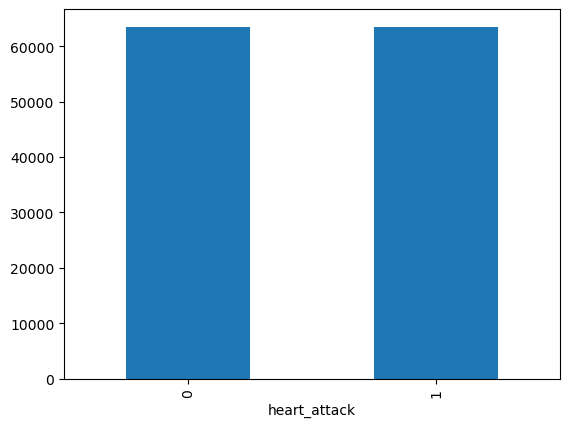

In [19]:
full_data_balanced.heart_attack.value_counts().plot(kind='bar')

## We now apply standardization, since some models like Knn need it to work properly

In [20]:
scaler = StandardScaler()

X_balanced = scaler.fit_transform(X_balanced)

## We will not include feature selection in the preprocessing, since the elimination of irrelevant features are more important for algorithms like KNN (in where we'll do this process with specific criteria), and it is better to not remove an arbitrary number of features with the least MI scores

## Now, we will apply the standardization in our entire dataset, and save a version with our full data + nomalization

In [32]:
scaler = StandardScaler()
num_d = [x for x in full_data_balanced.columns if x != "heart_attack"]
# update the cols with their normalized values
full_data_balanced_normalized = full_data_balanced
full_data_balanced_normalized[num_d] = scaler.fit_transform(full_data_balanced_normalized[num_d])

full_data_balanced_normalized


,age,hypertension,diabetes,cholesterol_level,obesity,waist_circumference,family_history,sleep_hours,blood_pressure_systolic,blood_pressure_diastolic,...,alcohol_consumption_None,physical_activity_Low,physical_activity_Moderate,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Moderate,stress_level_Low,stress_level_Moderate,EKG_results_Normal,heart_attack
0,-0.191687,-0.611612,-0.473831,0.819943,1.807022,-0.733750,1.527153,1.243393,0.098037,-0.851704,...,0.81734,1.224544,-0.812739,0.816858,1.528958,-0.998836,-0.498499,0.996715,0.495654,0
1,-0.445728,-0.611612,-0.473831,-0.325946,-0.553397,1.350383,-0.654813,-0.882546,1.367177,0.754118,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,1.001166,2.006022,-1.003296,-2.017536,0
2,0.231714,-0.611612,-0.473831,0.896336,-0.553397,-1.408028,-0.654813,1.568211,1.099990,-0.249521,...,-1.22348,1.224544,-0.812739,-1.224203,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
3,-1.885292,-0.611612,-0.473831,-0.147697,-0.553397,-1.162836,1.527153,0.875027,1.033193,-2.557890,...,-1.22348,-0.816630,-0.812739,0.816858,-0.654040,-0.998836,-0.498499,0.996715,0.495654,0
4,-0.530408,-0.611612,-0.473831,-1.650085,-0.553397,-0.978942,-0.654813,0.062720,0.565615,0.352663,...,0.81734,1.224544,-0.812739,-1.224203,-0.654040,1.001166,-0.498499,0.996715,0.495654,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127025,-1.207850,-0.611612,-0.473831,-1.573692,1.807022,0.063124,-0.654813,-0.167232,1.033193,-0.048793,...,0.81734,-0.816630,1.230407,-1.224203,-0.654040,1.001166,-0.498499,0.996715,-2.017536,1
127026,-1.800612,1.635022,-0.473831,0.132409,-0.553397,0.921297,1.527153,1.152472,0.098037,0.051571,...,0.81734,1.224544,-0.812739,0.816858,-0.654040,1.001166,-0.498499,0.996715,0.495654,1
127027,0.824475,-0.611612,-0.473831,-0.504196,-0.553397,0.001826,-0.654813,0.682472,0.164834,-0.650976,...,0.81734,-0.816630,1.230407,-1.224203,-0.654040,-0.998836,-0.498499,-1.003296,0.495654,1
127028,-2.054652,-0.611612,-0.473831,0.539837,-0.553397,-0.917644,-0.654813,1.074393,0.231631,0.754118,...,-1.22348,1.224544,-0.812739,-1.224203,1.528958,-0.998836,-0.498499,0.996715,-2.017536,1


In [54]:
full_data_balanced_normalized.to_csv("data_balanced_normalized.csv", index=False)